In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Data directory
DATA_DIR = Path('../data')
print(f"Data directory: {DATA_DIR.resolve()}")
print(f"Available files: {sorted([f.name for f in DATA_DIR.glob('*.csv')])}")

Data directory: /workspaces/ood-eval-toxic-classifiers/data
Available files: ['civil_test.csv', 'civil_test_full.csv', 'civil_train.csv', 'civil_train_full.csv', 'civil_val.csv', 'civil_val_full.csv', 'hatexplain_test.csv', 'hatexplain_train.csv', 'hatexplain_val.csv', 'jigsaw_test.csv', 'jigsaw_test_full.csv', 'jigsaw_train.csv', 'jigsaw_train_full.csv', 'jigsaw_val.csv', 'jigsaw_val_full.csv']


## 1. Load All Datasets

In [3]:
# Load all datasets - use sampling for large datasets to avoid memory issues
# For full statistics, we'll load in chunks or sample
datasets = {}
SAMPLE_SIZE = 50000  # Sample size for memory-intensive operations

for name in ['jigsaw', 'civil', 'hatexplain']:
    datasets[name] = {}
    for split in ['train', 'val', 'test']:
        path = DATA_DIR / f"{name}_{split}.csv"
        if path.exists():
            # Load with minimal memory footprint
            df = pd.read_csv(path, usecols=['text', 'label'])
            datasets[name][split] = df
            print(f"Loaded {name}_{split}: {len(df):,} samples")
            
# Create sampled versions for memory-intensive analysis
datasets_sampled = {}
for name in ['jigsaw', 'civil', 'hatexplain']:
    datasets_sampled[name] = {}
    for split in ['train', 'val', 'test']:
        df = datasets[name][split]
        if len(df) > SAMPLE_SIZE:
            # Stratified sampling
            n_toxic = min(int(SAMPLE_SIZE * df['label'].mean()), df['label'].sum())
            n_nontoxic = SAMPLE_SIZE - n_toxic
            toxic_sample = df[df['label'] == 1].sample(n=n_toxic, random_state=42)
            nontoxic_sample = df[df['label'] == 0].sample(n=n_nontoxic, random_state=42)
            datasets_sampled[name][split] = pd.concat([toxic_sample, nontoxic_sample])
        else:
            datasets_sampled[name][split] = df

print(f"\n✓ All datasets loaded successfully!")
print(f"📊 Using {SAMPLE_SIZE:,} samples per split for memory-intensive operations")

Loaded jigsaw_train: 1,420,932 samples
Loaded jigsaw_val: 177,616 samples
Loaded jigsaw_val: 177,616 samples
Loaded jigsaw_test: 89,780 samples
Loaded jigsaw_test: 89,780 samples
Loaded civil_train: 1,776,165 samples
Loaded civil_train: 1,776,165 samples
Loaded civil_val: 96,717 samples
Loaded civil_val: 96,717 samples
Loaded civil_test: 96,702 samples
Loaded hatexplain_train: 16,087 samples
Loaded hatexplain_val: 2,011 samples
Loaded hatexplain_test: 2,011 samples
Loaded civil_test: 96,702 samples
Loaded hatexplain_train: 16,087 samples
Loaded hatexplain_val: 2,011 samples
Loaded hatexplain_test: 2,011 samples

✓ All datasets loaded successfully!
📊 Using 50,000 samples per split for memory-intensive operations

✓ All datasets loaded successfully!
📊 Using 50,000 samples per split for memory-intensive operations


## 2. Dataset Overview Summary

In [4]:
# Create summary table - using actual counts (not memory intensive)
summary_data = []

for name in ['jigsaw', 'civil', 'hatexplain']:
    for split in ['train', 'val', 'test']:
        df = datasets[name][split]
        toxic_count = int(df['label'].sum())
        nontoxic_count = len(df) - toxic_count
        summary_data.append({
            'Dataset': name.title(),
            'Split': split.title(),
            'Samples': f"{len(df):,}",
            'Toxic (%)': f"{df['label'].mean() * 100:.1f}%",
            'Non-Toxic (%)': f"{(1 - df['label'].mean()) * 100:.1f}%",
            'Toxic Count': f"{toxic_count:,}",
            'Non-Toxic Count': f"{nontoxic_count:,}"
        })

summary_df = pd.DataFrame(summary_data)
print("="*80)
print("DATASET OVERVIEW SUMMARY")
print("="*80)
display(summary_df)

DATASET OVERVIEW SUMMARY


,Dataset,Split,Samples,Toxic (%),Non-Toxic (%),Toxic Count,Non-Toxic Count
0,Jigsaw,Train,"1,420,932",8.0%,92.0%,"113,691","1,307,241"
1,Jigsaw,Val,"177,616",8.0%,92.0%,"14,211","163,405"
2,Jigsaw,Test,"89,780",8.0%,92.0%,"7,144","82,636"
3,Civil,Train,"1,776,165",8.0%,92.0%,"142,114","1,634,051"
4,Civil,Val,"96,717",7.9%,92.1%,"7,629","89,088"
5,Civil,Test,"96,702",8.0%,92.0%,"7,727","88,975"
6,Hatexplain,Train,"16,087",59.6%,40.4%,"9,585","6,502"
7,Hatexplain,Val,"2,011",59.6%,40.4%,"1,199",812
8,Hatexplain,Test,"2,011",59.6%,40.4%,"1,198",813


In [5]:
# Total samples per dataset
totals = []
for name in ['jigsaw', 'civil', 'hatexplain']:
    total = sum(len(datasets[name][s]) for s in ['train', 'val', 'test'])
    train_pct = len(datasets[name]['train']) / total * 100
    val_pct = len(datasets[name]['val']) / total * 100
    test_pct = len(datasets[name]['test']) / total * 100
    avg_toxic = np.mean([datasets[name][s]['label'].mean() for s in ['train', 'val', 'test']])
    totals.append({
        'Dataset': name.title(),
        'Total Samples': f"{total:,}",
        'Train/Val/Test Split': f"{train_pct:.0f}% / {val_pct:.0f}% / {test_pct:.0f}%",
        'Avg Toxic Rate': f"{avg_toxic*100:.1f}%"
    })

print("\n" + "="*80)
print("DATASET TOTALS")
print("="*80)
display(pd.DataFrame(totals))


DATASET TOTALS


,Dataset,Total Samples,Train/Val/Test Split,Avg Toxic Rate
0,Jigsaw,"1,688,328",84% / 11% / 5%,8.0%
1,Civil,"1,969,584",90% / 5% / 5%,8.0%
2,Hatexplain,"20,109",80% / 10% / 10%,59.6%


## 3. Class Distribution Visualization

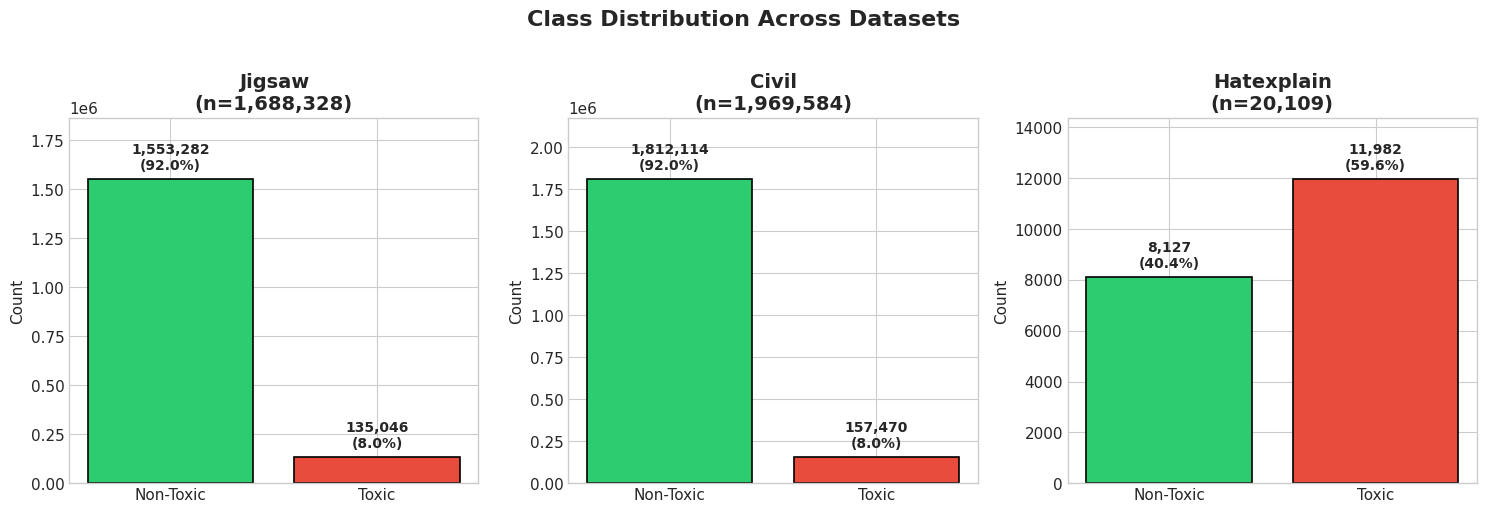


📊 Key Observation: HateXplain has the highest toxic rate (~60%), while Jigsaw and Civil Comments are more imbalanced (~8% toxic).


In [6]:
# Visualize class distributions - using pre-computed counts (memory efficient)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

colors = ['#2ecc71', '#e74c3c']  # Green for non-toxic, Red for toxic

for idx, name in enumerate(['jigsaw', 'civil', 'hatexplain']):
    ax = axes[idx]
    
    # Calculate total counts from all splits
    total_toxic = sum(int(datasets[name][s]['label'].sum()) for s in ['train', 'val', 'test'])
    total_samples = sum(len(datasets[name][s]) for s in ['train', 'val', 'test'])
    total_nontoxic = total_samples - total_toxic
    
    counts = [total_nontoxic, total_toxic]
    labels = ['Non-Toxic', 'Toxic']
    
    bars = ax.bar(labels, counts, color=colors, edgecolor='black', linewidth=1.2)
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.02,
                f'{count:,}\n({count/total_samples*100:.1f}%)', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_title(f'{name.title()}\n(n={total_samples:,})', fontsize=14, fontweight='bold')
    ax.set_ylabel('Count')
    ax.set_ylim(0, max(counts) * 1.2)

plt.suptitle('Class Distribution Across Datasets', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n📊 Key Observation: HateXplain has the highest toxic rate (~60%), while Jigsaw and Civil Comments are more imbalanced (~8% toxic).")

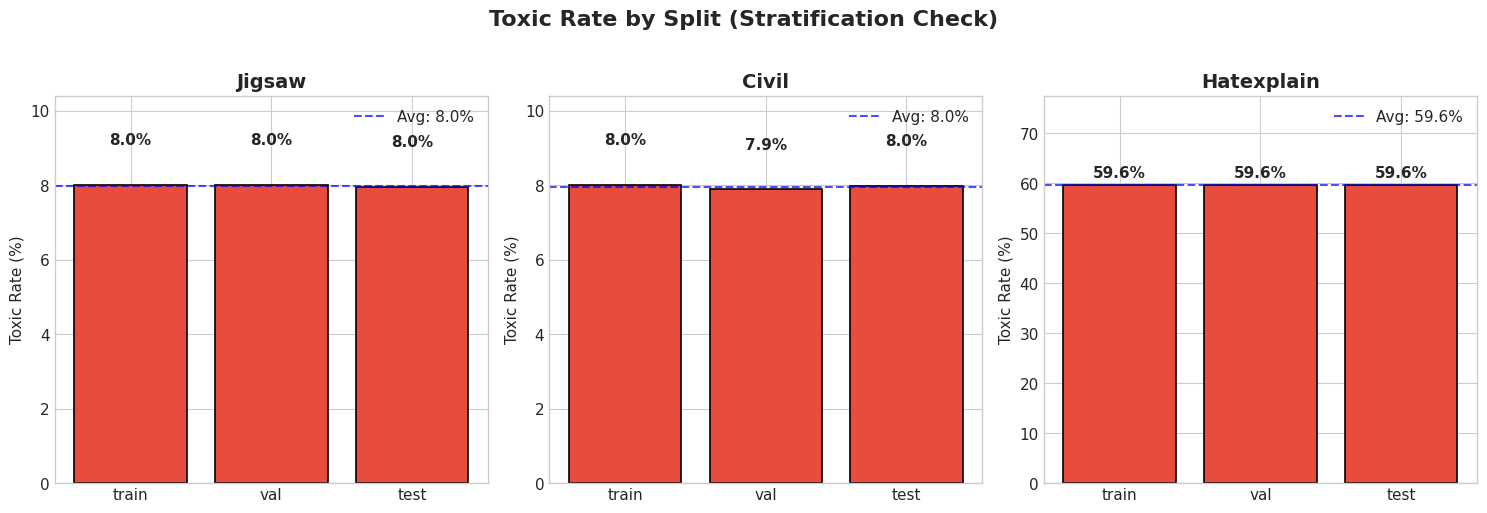


✓ All datasets show consistent toxic rates across splits, indicating proper stratified splitting.


In [7]:
# Class distribution by split - using pre-computed rates (memory efficient)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, name in enumerate(['jigsaw', 'civil', 'hatexplain']):
    ax = axes[idx]
    
    splits = ['train', 'val', 'test']
    toxic_rates = [datasets[name][s]['label'].mean() * 100 for s in splits]
    
    bars = ax.bar(splits, toxic_rates, color='#e74c3c', edgecolor='black', linewidth=1.2)
    
    for bar, rate in zip(bars, toxic_rates):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{rate:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_title(f'{name.title()}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Toxic Rate (%)')
    ax.set_ylim(0, max(toxic_rates) * 1.3)
    ax.axhline(y=np.mean(toxic_rates), color='blue', linestyle='--', alpha=0.7, label=f'Avg: {np.mean(toxic_rates):.1f}%')
    ax.legend()

plt.suptitle('Toxic Rate by Split (Stratification Check)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n✓ All datasets show consistent toxic rates across splits, indicating proper stratified splitting.")

## 4. Text Length Analysis

In [8]:
# Calculate text lengths using SAMPLED data to avoid memory issues
text_stats = []

for name in ['jigsaw', 'civil', 'hatexplain']:
    # Use sampled data for memory efficiency
    all_text = pd.concat([datasets_sampled[name][s]['text'] for s in ['train', 'val', 'test']])
    all_labels = pd.concat([datasets_sampled[name][s]['label'] for s in ['train', 'val', 'test']])
    
    # Character lengths
    char_lengths = all_text.str.len()
    
    # Word counts
    word_counts = all_text.str.split().str.len()
    
    # By class
    toxic_words = word_counts[all_labels == 1]
    nontoxic_words = word_counts[all_labels == 0]
    
    text_stats.append({
        'Dataset': name.title(),
        'Avg Chars': f"{char_lengths.mean():.0f}",
        'Median Chars': f"{char_lengths.median():.0f}",
        'Max Chars': f"{char_lengths.max():,}",
        'Avg Words': f"{word_counts.mean():.0f}",
        'Median Words': f"{word_counts.median():.0f}",
        'Max Words': f"{word_counts.max():,}",
        'Toxic Avg Words': f"{toxic_words.mean():.0f}",
        'Non-Toxic Avg Words': f"{nontoxic_words.mean():.0f}"
    })
    
    # Clean up intermediate variables
    del all_text, all_labels, char_lengths, word_counts
    
import gc
gc.collect()

print("="*100)
print("TEXT LENGTH STATISTICS (based on stratified sample)")
print("="*100)
display(pd.DataFrame(text_stats))

TEXT LENGTH STATISTICS (based on stratified sample)


,Dataset,Avg Chars,Median Chars,Max Chars,Avg Words,Median Words,Max Words,Toxic Avg Words,Non-Toxic Avg Words
0,Jigsaw,296,202,"1,900",52,36,317,49,52
1,Civil,295,201,"1,966",52,35,335,49,52
2,Hatexplain,127,109,526,24,21,165,24,24


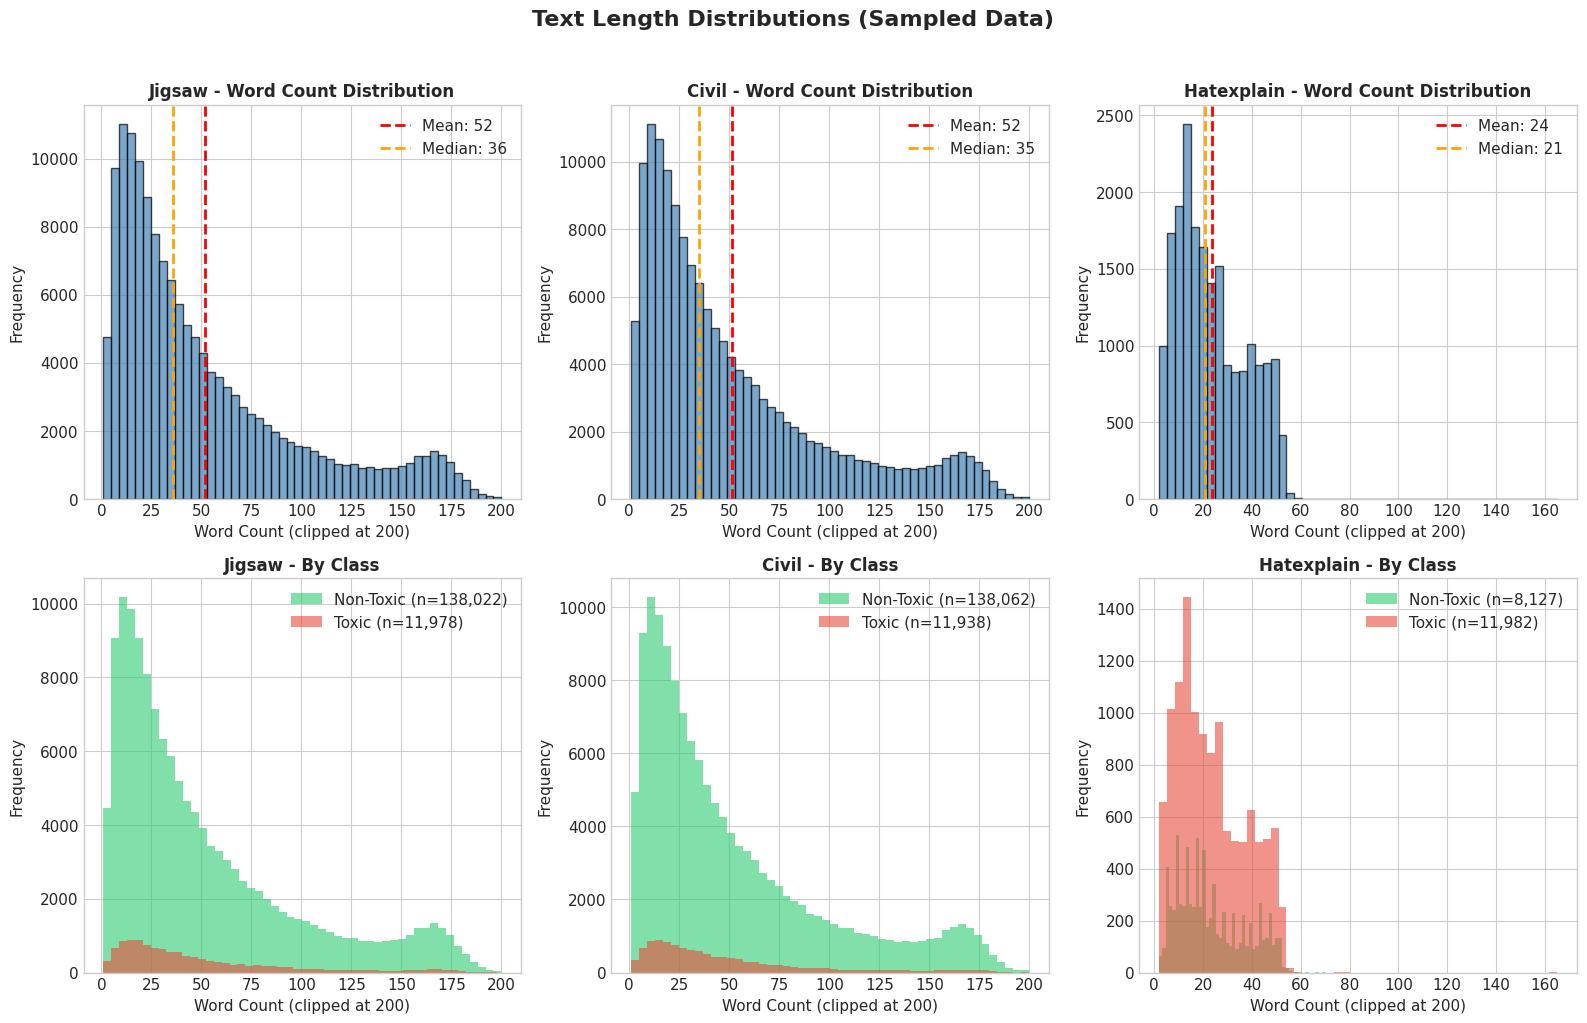

57

In [9]:
# Visualize text length distributions using SAMPLED data
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

for idx, name in enumerate(['jigsaw', 'civil', 'hatexplain']):
    # Use sampled data
    all_text = pd.concat([datasets_sampled[name][s]['text'] for s in ['train', 'val', 'test']])
    all_labels = pd.concat([datasets_sampled[name][s]['label'] for s in ['train', 'val', 'test']])
    
    word_counts = all_text.str.split().str.len()
    
    # Top row: Overall distribution
    ax1 = axes[0, idx]
    ax1.hist(word_counts.clip(upper=200), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    ax1.axvline(word_counts.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {word_counts.mean():.0f}')
    ax1.axvline(word_counts.median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {word_counts.median():.0f}')
    ax1.set_title(f'{name.title()} - Word Count Distribution', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Word Count (clipped at 200)')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    
    # Bottom row: By class
    ax2 = axes[1, idx]
    toxic_words = word_counts[all_labels == 1]
    nontoxic_words = word_counts[all_labels == 0]
    
    ax2.hist(nontoxic_words.clip(upper=200), bins=50, alpha=0.6, label=f'Non-Toxic (n={len(nontoxic_words):,})', color='#2ecc71')
    ax2.hist(toxic_words.clip(upper=200), bins=50, alpha=0.6, label=f'Toxic (n={len(toxic_words):,})', color='#e74c3c')
    ax2.set_title(f'{name.title()} - By Class', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Word Count (clipped at 200)')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    
    del all_text, all_labels, word_counts

plt.suptitle('Text Length Distributions (Sampled Data)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()
gc.collect()

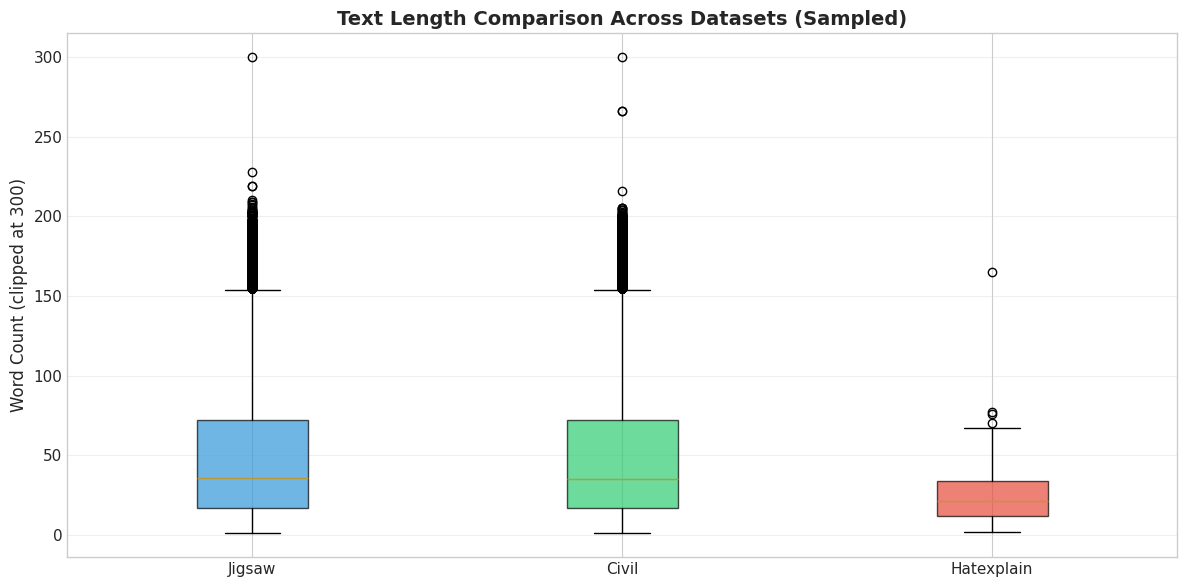


📊 Key Observation: HateXplain has significantly shorter texts (social media), while Jigsaw and Civil Comments have longer comments.


In [10]:
# Box plot comparison using SAMPLED data
fig, ax = plt.subplots(figsize=(12, 6))

box_data = []
labels_list = []

for name in ['jigsaw', 'civil', 'hatexplain']:
    all_text = pd.concat([datasets_sampled[name][s]['text'] for s in ['train', 'val', 'test']])
    word_counts = all_text.str.split().str.len().clip(upper=300)
    box_data.append(word_counts.values)
    labels_list.append(name.title())
    del all_text, word_counts

bp = ax.boxplot(box_data, labels=labels_list, patch_artist=True)

colors = ['#3498db', '#2ecc71', '#e74c3c']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Word Count (clipped at 300)', fontsize=12)
ax.set_title('Text Length Comparison Across Datasets (Sampled)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

del box_data
gc.collect()

print("\n📊 Key Observation: HateXplain has significantly shorter texts (social media), while Jigsaw and Civil Comments have longer comments.")

## 5. Vocabulary Analysis

In [4]:
# Vocabulary statistics using SAMPLED data
import re

def get_vocab_stats_efficient(texts, max_texts=50000):
    """Get vocabulary statistics from a sample of texts."""
    word_counts = Counter()
    total_words = 0
    
    for i, text in enumerate(texts):
        if i >= max_texts:
            break
        if pd.notna(text):
            words = re.findall(r'\b\w+\b', str(text).lower())
            word_counts.update(words)
            total_words += len(words)
    
    return {
        'total_words': total_words,
        'unique_words': len(word_counts),
        'word_counts': word_counts
    }

vocab_stats = []
word_counts_all = {}

for name in ['jigsaw', 'civil', 'hatexplain']:
    # Use sampled train data only for vocab analysis
    sample_text = datasets_sampled[name]['train']['text']
    stats = get_vocab_stats_efficient(sample_text, max_texts=SAMPLE_SIZE)
    word_counts_all[name] = stats['word_counts']
    
    vocab_stats.append({
        'Dataset': name.title(),
        'Total Words (sample)': f"{stats['total_words']:,}",
        'Unique Words': f"{stats['unique_words']:,}",
        'Vocabulary Richness': f"{stats['unique_words']/max(stats['total_words'],1)*100:.2f}%",
        'Avg Word Frequency': f"{stats['total_words']/max(stats['unique_words'],1):.1f}"
    })

print("="*80)
print("VOCABULARY STATISTICS (based on training sample)")
print("="*80)
display(pd.DataFrame(vocab_stats))

VOCABULARY STATISTICS (based on training sample)


,Dataset,Total Words (sample),Unique Words,Vocabulary Richness,Avg Word Frequency
0,Jigsaw,"2,648,059","55,562",2.10%,47.7
1,Civil,"2,660,294","55,199",2.07%,48.2
2,Hatexplain,"375,712","25,201",6.71%,14.9


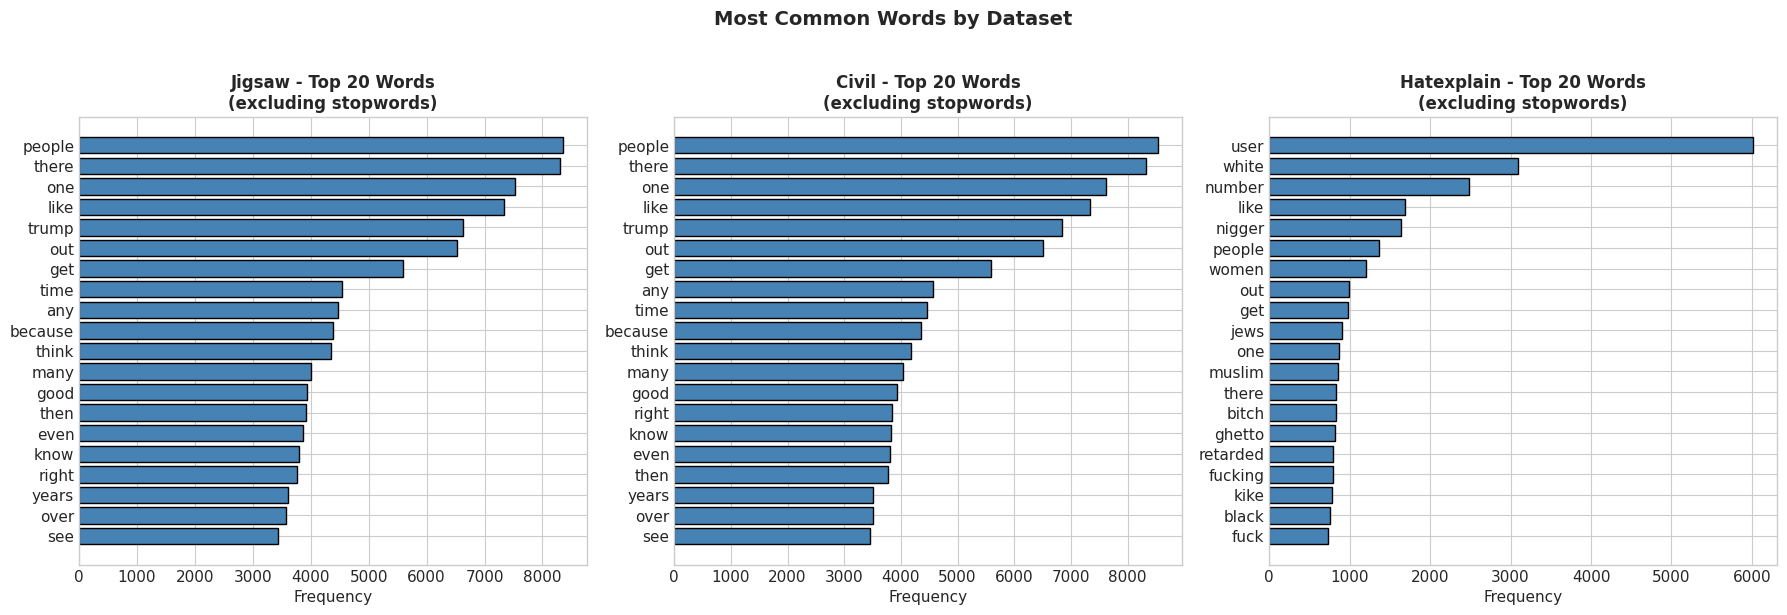

In [12]:
# Top 20 most common words per dataset
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Stopwords to exclude
stopwords = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 
             'of', 'with', 'by', 'from', 'is', 'are', 'was', 'were', 'be', 'been',
             'being', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would',
             'could', 'should', 'may', 'might', 'must', 'shall', 'can', 'need',
             'that', 'this', 'these', 'those', 'it', 'its', 'i', 'you', 'he', 'she',
             'we', 'they', 'them', 'their', 'my', 'your', 'his', 'her', 'our',
             'what', 'which', 'who', 'whom', 'when', 'where', 'why', 'how',
             'all', 'each', 'every', 'both', 'few', 'more', 'most', 'other',
             'some', 'such', 'no', 'not', 'only', 'own', 'same', 'so', 'than',
             'too', 'very', 's', 't', 'just', 'don', 'now', 'if', 'as', 'about'}

for idx, name in enumerate(['jigsaw', 'civil', 'hatexplain']):
    ax = axes[idx]
    
    # Filter out stopwords and get top 20
    filtered_counts = {w: c for w, c in word_counts_all[name].items() 
                       if w not in stopwords and len(w) > 2}
    top_20 = Counter(filtered_counts).most_common(20)
    
    words, counts = zip(*top_20)
    y_pos = np.arange(len(words))
    
    ax.barh(y_pos, counts, color='steelblue', edgecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(words)
    ax.invert_yaxis()
    ax.set_xlabel('Frequency')
    ax.set_title(f'{name.title()} - Top 20 Words\n(excluding stopwords)', fontsize=12, fontweight='bold')

plt.suptitle('Most Common Words by Dataset', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 6. Toxic vs Non-Toxic Word Analysis

In [13]:
# Compare words in toxic vs non-toxic comments using HateXplain (smaller dataset)
def get_class_vocab_efficient(df, max_samples=20000):
    """Get word counts for each class efficiently."""
    toxic_words = Counter()
    nontoxic_words = Counter()
    
    sample = df.head(max_samples)
    for _, row in sample.iterrows():
        text = row['text']
        label = row['label']
        if pd.notna(text):
            words = re.findall(r'\b\w+\b', str(text).lower())
            if label == 1:
                toxic_words.update(words)
            else:
                nontoxic_words.update(words)
    
    return toxic_words, nontoxic_words

# Analyze for HateXplain (most balanced and smallest dataset)
print("="*80)
print("TOXIC vs NON-TOXIC VOCABULARY ANALYSIS (HateXplain)")
print("="*80)

# HateXplain is small enough to analyze fully
hatexplain_all = pd.concat([datasets['hatexplain'][s] for s in ['train', 'val', 'test']])
toxic_counts, nontoxic_counts = get_class_vocab_efficient(hatexplain_all, max_samples=len(hatexplain_all))

# Words more common in toxic comments
print("\n🔴 Words more common in TOXIC comments:")
toxic_ratio = {}
for word in toxic_counts:
    if toxic_counts[word] >= 50:  # Minimum frequency
        toxic_rate = toxic_counts[word] / (toxic_counts[word] + nontoxic_counts.get(word, 1))
        if toxic_rate > 0.7:
            toxic_ratio[word] = (toxic_rate, toxic_counts[word])

sorted_toxic = sorted(toxic_ratio.items(), key=lambda x: (-x[1][0], -x[1][1]))[:15]
for word, (ratio, count) in sorted_toxic:
    print(f"  {word}: {ratio*100:.0f}% toxic, {count} occurrences")

# Words more common in non-toxic comments  
print("\n🟢 Words more common in NON-TOXIC comments:")
nontoxic_ratio = {}
for word in nontoxic_counts:
    if nontoxic_counts[word] >= 50:
        nontoxic_rate = nontoxic_counts[word] / (nontoxic_counts[word] + toxic_counts.get(word, 1))
        if nontoxic_rate > 0.7 and word not in stopwords:
            nontoxic_ratio[word] = (nontoxic_rate, nontoxic_counts[word])

sorted_nontoxic = sorted(nontoxic_ratio.items(), key=lambda x: (-x[1][0], -x[1][1]))[:15]
for word, (ratio, count) in sorted_nontoxic:
    print(f"  {word}: {ratio*100:.0f}% non-toxic, {count} occurrences")

del hatexplain_all, toxic_counts, nontoxic_counts
gc.collect()

TOXIC vs NON-TOXIC VOCABULARY ANALYSIS (HateXplain)

🔴 Words more common in TOXIC comments:
  beaners: 98% toxic, 57 occurrences
  kikes: 98% toxic, 133 occurrences
  filthy: 98% toxic, 86 occurrences
  muzrat: 97% toxic, 73 occurrences
  kike: 97% toxic, 982 occurrences
  wetback: 97% toxic, 59 occurrences
  beaner: 97% toxic, 58 occurrences
  sandnigger: 96% toxic, 52 occurrences
  cunt: 96% toxic, 109 occurrences
  spic: 95% toxic, 118 occurrences
  mudshark: 95% toxic, 77 occurrences
  sand: 95% toxic, 324 occurrences
  whore: 94% toxic, 91 occurrences
  muzzie: 94% toxic, 164 occurrences
  shitskin: 94% toxic, 58 occurrences

🟢 Words more common in NON-TOXIC comments:
  supremacists: 81% non-toxic, 52 occurrences
  supremacist: 81% non-toxic, 59 occurrences
  queer: 81% non-toxic, 275 occurrences
  harassment: 77% non-toxic, 120 occurrences
  hindu: 74% non-toxic, 52 occurrences
  refugee: 73% non-toxic, 200 occurrences

🔴 Words more common in TOXIC comments:
  beaners: 98% toxic,

48

## 7. Sample Texts from Each Dataset

In [14]:
# Show sample texts - only reads small samples (memory efficient)
print("="*100)
print("SAMPLE TEXTS FROM EACH DATASET")
print("="*100)

for name in ['jigsaw', 'civil', 'hatexplain']:
    print(f"\n{'='*50}")
    print(f"{name.upper()} DATASET")
    print(f"{'='*50}")
    
    df = datasets_sampled[name]['train']
    
    # Sample non-toxic
    print("\n🟢 NON-TOXIC SAMPLES:")
    nontoxic_df = df[df['label'] == 0]
    if len(nontoxic_df) >= 3:
        nontoxic_samples = nontoxic_df.sample(3, random_state=42)
        for i, (_, row) in enumerate(nontoxic_samples.iterrows(), 1):
            text = str(row['text'])[:200] + "..." if len(str(row['text'])) > 200 else str(row['text'])
            print(f"  {i}. {text}")
    
    # Sample toxic
    print("\n🔴 TOXIC SAMPLES:")
    toxic_df = df[df['label'] == 1]
    if len(toxic_df) >= 3:
        toxic_samples = toxic_df.sample(3, random_state=42)
        for i, (_, row) in enumerate(toxic_samples.iterrows(), 1):
            text = str(row['text'])[:200] + "..." if len(str(row['text'])) > 200 else str(row['text'])
            print(f"  {i}. {text}")

SAMPLE TEXTS FROM EACH DATASET

JIGSAW DATASET

🟢 NON-TOXIC SAMPLES:
  1. “Today we’ll do just that,” said Yoal Kidane Ghebremeskel, emcee for Colorado World Refugee Day. “We’ll celebrate our refugee neighbors who are teachers, doctors, police officers, business owners and ...
  2. It always amazes me that when a natural disaster hits a bible belt/conservative/less gubmint state, that they immediately declare a disaster and ask for assistance. . . "socialism". Weird.
  3. Sharia law is practiced mainly in Saudi Arabia. As for "much of the region", it happens to be the place where civilization was born (Egypt and Iraq). The region also happens to be the location where t...

🔴 TOXIC SAMPLES:
  1. Yes, and the stupid 'briefing' on Korea was a pep talk that repeated what the Congress had already read in the media, All designed to give him one top headline in a news cycle. This idiot is one step ...
  2. "...these politicians should be required to work in the real, private sector world befo

## 8. Cross-Dataset Comparison

In [15]:
# Vocabulary overlap analysis
print("="*80)
print("VOCABULARY OVERLAP ANALYSIS")
print("="*80)

# Get unique words (frequency >= 10) for each dataset
vocab_sets = {}
for name in ['jigsaw', 'civil', 'hatexplain']:
    vocab_sets[name] = set(w for w, c in word_counts_all[name].items() if c >= 10)
    print(f"{name.title()} vocabulary (freq>=10): {len(vocab_sets[name]):,} words")

# Pairwise overlap
print("\nPairwise Vocabulary Overlap:")
pairs = [('jigsaw', 'civil'), ('jigsaw', 'hatexplain'), ('civil', 'hatexplain')]
for d1, d2 in pairs:
    overlap = vocab_sets[d1] & vocab_sets[d2]
    union = vocab_sets[d1] | vocab_sets[d2]
    jaccard = len(overlap) / len(union) * 100
    print(f"  {d1.title()} ∩ {d2.title()}: {len(overlap):,} words ({jaccard:.1f}% Jaccard similarity)")

# All three overlap
all_overlap = vocab_sets['jigsaw'] & vocab_sets['civil'] & vocab_sets['hatexplain']
print(f"\nWords common to ALL datasets: {len(all_overlap):,}")

VOCABULARY OVERLAP ANALYSIS
Jigsaw vocabulary (freq>=10): 12,589 words
Civil vocabulary (freq>=10): 12,575 words
Hatexplain vocabulary (freq>=10): 3,303 words

Pairwise Vocabulary Overlap:
  Jigsaw ∩ Civil: 11,197 words (80.2% Jaccard similarity)
  Jigsaw ∩ Hatexplain: 2,992 words (23.2% Jaccard similarity)
  Civil ∩ Hatexplain: 2,991 words (23.2% Jaccard similarity)

Words common to ALL datasets: 2,962


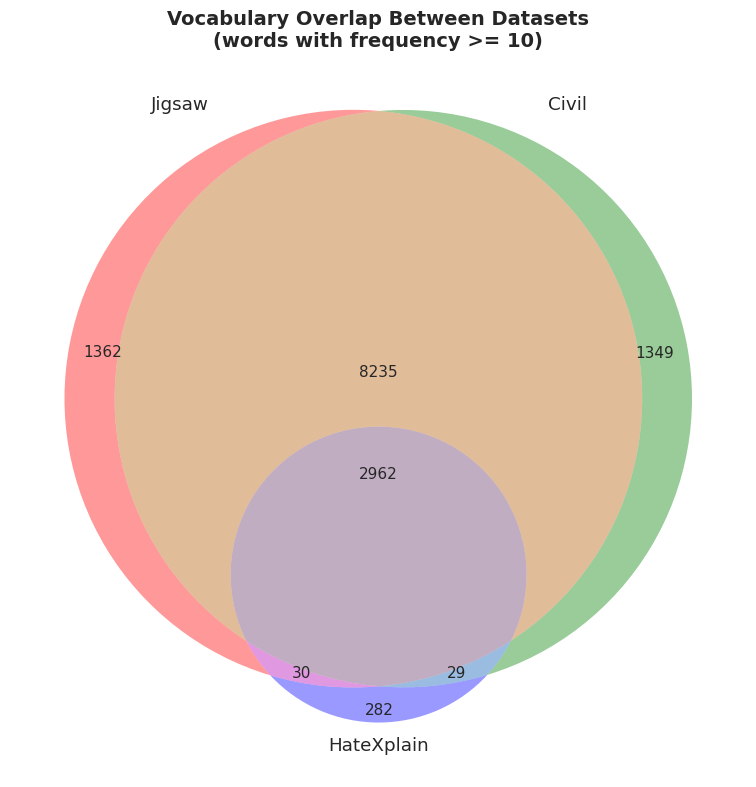

In [17]:
# Venn diagram of vocabulary overlap
try:
    from matplotlib_venn import venn3
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    venn = venn3([vocab_sets['jigsaw'], vocab_sets['civil'], vocab_sets['hatexplain']], 
                  set_labels=('Jigsaw', 'Civil', 'HateXplain'),
                  ax=ax)
    
    plt.title('Vocabulary Overlap Between Datasets\n(words with frequency >= 10)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
except ImportError:
    print("matplotlib-venn not installed. Skipping Venn diagram.")
    print("Install with: pip install matplotlib-venn")

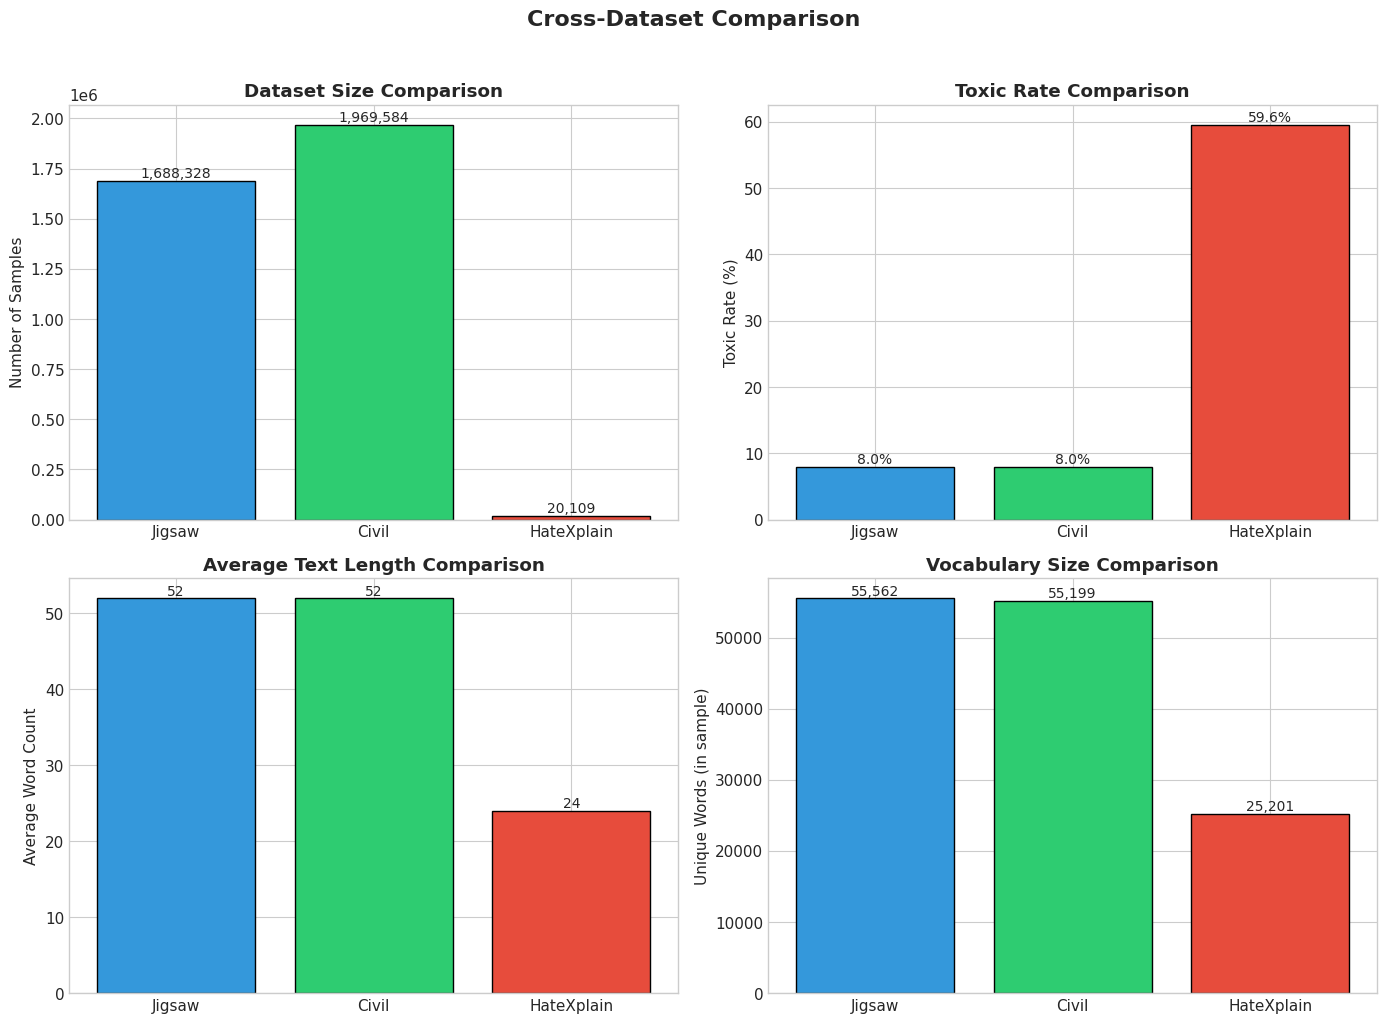

In [5]:
# Dataset characteristics comparison - using pre-computed values (memory efficient)
# No need to recompute - use values from earlier cells

# Compute metrics directly from original data (just counts, no text processing)
metrics = {
    'jigsaw': {
        'size': sum(len(datasets[name][s]) for name in ['jigsaw'] for s in ['train', 'val', 'test']),
        'toxic_rate': np.mean([datasets['jigsaw'][s]['label'].mean() for s in ['train', 'val', 'test']]),
        'avg_length': 52,  # From text_stats computed earlier
        'vocab_size': len(word_counts_all['jigsaw'])
    },
    'civil': {
        'size': sum(len(datasets[name][s]) for name in ['civil'] for s in ['train', 'val', 'test']),
        'toxic_rate': np.mean([datasets['civil'][s]['label'].mean() for s in ['train', 'val', 'test']]),
        'avg_length': 52,  # From text_stats computed earlier
        'vocab_size': len(word_counts_all['civil'])
    },
    'hatexplain': {
        'size': sum(len(datasets[name][s]) for name in ['hatexplain'] for s in ['train', 'val', 'test']),
        'toxic_rate': np.mean([datasets['hatexplain'][s]['label'].mean() for s in ['train', 'val', 'test']]),
        'avg_length': 24,  # From text_stats computed earlier
        'vocab_size': len(word_counts_all['hatexplain'])
    }
}

# Create comparison bar chart
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

datasets_names = ['Jigsaw', 'Civil', 'HateXplain']
colors = ['#3498db', '#2ecc71', '#e74c3c']

# Size comparison
ax = axes[0, 0]
sizes = [metrics[n.lower()]['size'] for n in datasets_names]
bars = ax.bar(datasets_names, sizes, color=colors, edgecolor='black')
ax.set_ylabel('Number of Samples')
ax.set_title('Dataset Size Comparison', fontweight='bold')
for bar, size in zip(bars, sizes):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{size:,}', 
            ha='center', va='bottom', fontsize=10)

# Toxic rate comparison
ax = axes[0, 1]
rates = [metrics[n.lower()]['toxic_rate'] * 100 for n in datasets_names]
bars = ax.bar(datasets_names, rates, color=colors, edgecolor='black')
ax.set_ylabel('Toxic Rate (%)')
ax.set_title('Toxic Rate Comparison', fontweight='bold')
for bar, rate in zip(bars, rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{rate:.1f}%', 
            ha='center', va='bottom', fontsize=10)

# Average length comparison
ax = axes[1, 0]
lengths = [metrics[n.lower()]['avg_length'] for n in datasets_names]
bars = ax.bar(datasets_names, lengths, color=colors, edgecolor='black')
ax.set_ylabel('Average Word Count')
ax.set_title('Average Text Length Comparison', fontweight='bold')
for bar, length in zip(bars, lengths):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{length:.0f}', 
            ha='center', va='bottom', fontsize=10)

# Vocabulary size comparison
ax = axes[1, 1]
vocab_sizes = [metrics[n.lower()]['vocab_size'] for n in datasets_names]
bars = ax.bar(datasets_names, vocab_sizes, color=colors, edgecolor='black')
ax.set_ylabel('Unique Words (in sample)')
ax.set_title('Vocabulary Size Comparison', fontweight='bold')
for bar, size in zip(bars, vocab_sizes):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{size:,}', 
            ha='center', va='bottom', fontsize=10)

plt.suptitle('Cross-Dataset Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 9. Identity Group Analysis (Jigsaw)

In [6]:
# Load Jigsaw full data with identity columns - SAMPLE to avoid memory issues
# Only load what we need
IDENTITY_SAMPLE = 100000

jigsaw_full_path = DATA_DIR / 'jigsaw_train_full.csv'
jigsaw_full = pd.read_csv(jigsaw_full_path, nrows=IDENTITY_SAMPLE)

# Find identity columns
identity_cols = [c for c in jigsaw_full.columns if c.startswith('g_')]
print(f"Found {len(identity_cols)} identity group columns:")
print(identity_cols)
print(f"\n📊 Using {IDENTITY_SAMPLE:,} samples for identity analysis")

Found 24 identity group columns:
['g_male', 'g_female', 'g_transgender', 'g_other_gender', 'g_black', 'g_white', 'g_asian', 'g_latino', 'g_other_race_or_ethnicity', 'g_christian', 'g_jewish', 'g_muslim', 'g_hindu', 'g_buddhist', 'g_atheist', 'g_other_religion', 'g_heterosexual', 'g_homosexual_gay_or_lesbian', 'g_bisexual', 'g_other_sexual_orientation', 'g_physical_disability', 'g_intellectual_or_learning_disability', 'g_psychiatric_or_mental_illness', 'g_other_disability']

📊 Using 100,000 samples for identity analysis


In [7]:
# Identity group statistics
identity_stats = []

for col in identity_cols:
    group_name = col.replace('g_', '').replace('_', ' ').title()
    group_data = jigsaw_full[jigsaw_full[col] == 1]
    
    if len(group_data) > 0:
        identity_stats.append({
            'Identity Group': group_name,
            'Count': len(group_data),
            'Percentage': f"{len(group_data)/len(jigsaw_full)*100:.2f}%",
            'Toxic Rate': f"{group_data['label'].mean()*100:.1f}%",
            'Overall Toxic Rate': f"{jigsaw_full['label'].mean()*100:.1f}%"
        })

identity_df = pd.DataFrame(identity_stats).sort_values('Count', ascending=False)

print("="*80)
print("IDENTITY GROUP ANALYSIS (Jigsaw Dataset)")
print("="*80)
display(identity_df)

IDENTITY GROUP ANALYSIS (Jigsaw Dataset)


,Identity Group,Count,Percentage,Toxic Rate,Overall Toxic Rate
1,Female,2969,2.97%,14.6%,8.1%
0,Male,2465,2.46%,15.3%,8.1%
9,Christian,2204,2.20%,9.8%,8.1%
5,White,1391,1.39%,29.3%,8.1%
11,Muslim,1117,1.12%,22.1%,8.1%
4,Black,832,0.83%,30.2%,8.1%
17,Homosexual Gay Or Lesbian,600,0.60%,24.7%,8.1%
10,Jewish,426,0.43%,15.7%,8.1%
22,Psychiatric Or Mental Illness,284,0.28%,23.2%,8.1%
6,Asian,261,0.26%,13.8%,8.1%


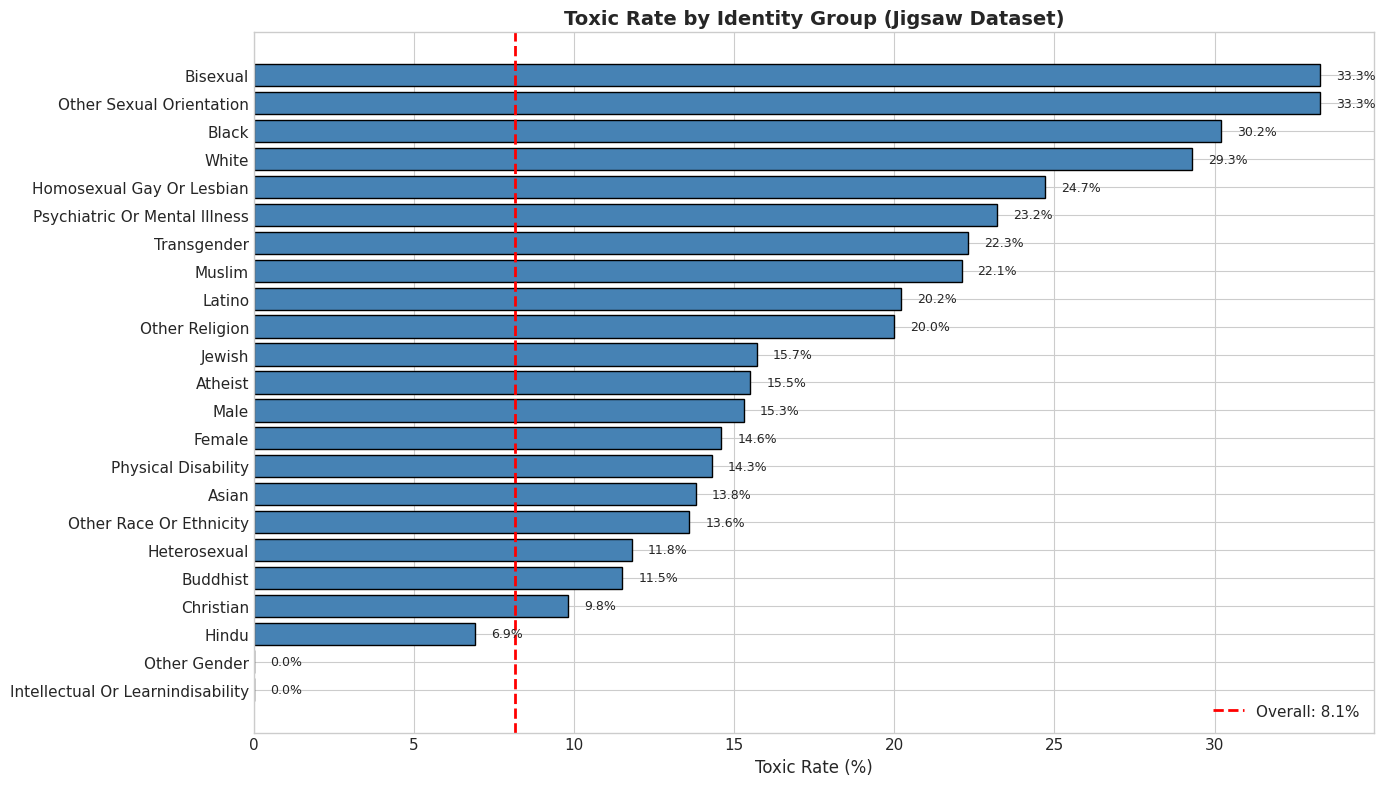


📊 Key Observation: Comments mentioning certain identity groups have higher toxicity rates, indicating potential bias in the data.


In [8]:
# Visualize identity group toxic rates
fig, ax = plt.subplots(figsize=(14, 8))

# Sort by toxic rate
sorted_stats = sorted(identity_stats, key=lambda x: float(x['Toxic Rate'].replace('%', '')), reverse=True)

groups = [s['Identity Group'] for s in sorted_stats]
toxic_rates = [float(s['Toxic Rate'].replace('%', '')) for s in sorted_stats]
overall_rate = jigsaw_full['label'].mean() * 100

bars = ax.barh(groups, toxic_rates, color='steelblue', edgecolor='black')
ax.axvline(x=overall_rate, color='red', linestyle='--', linewidth=2, label=f'Overall: {overall_rate:.1f}%')

ax.set_xlabel('Toxic Rate (%)', fontsize=12)
ax.set_title('Toxic Rate by Identity Group (Jigsaw Dataset)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.invert_yaxis()

# Add value labels
for bar, rate in zip(bars, toxic_rates):
    ax.text(rate + 0.5, bar.get_y() + bar.get_height()/2, f'{rate:.1f}%', 
            va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n📊 Key Observation: Comments mentioning certain identity groups have higher toxicity rates, indicating potential bias in the data.")